In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [58]:
df=pd.read_csv('new_train2.csv')
test=pd.read_csv('new_test.csv')

In [59]:
df.head()

age           job   marital          education  default housing loan  \
0   49   blue-collar   married           basic.9y  unknown      no   no   
1   37  entrepreneur   married  university.degree       no      no   no   
2   55       retired   married           basic.4y       no      no   no   
3   36        admin.   married  university.degree       no     yes   no   
4   55       retired  divorced  university.degree       no      no   no   

     contact month day_of_week  duration  campaign     poutcome    y  
0   cellular   nov         wed       227         4  nonexistent   no  
1  telephone   nov         wed       202         2      failure   no  
2   cellular   jul         mon       550         1  nonexistent  yes  
3  telephone   may         mon       120         2  nonexistent   no  
4   cellular   jun         tue       368         2  nonexistent   no

In [60]:
df['label'] = df['y'].apply(lambda x:1 if x=='yes' else 0)
del df['y']

In [61]:
X = df.iloc[:, 0:-1]
Y = df.iloc[:, -1]

In [62]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = ['age', 'duration', 'campaign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [63]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, Y=None, **fit_params):
        return self
    
    def transform(self, X, Y=None, **fit_params):
        return X.toarray()

In [64]:
def train_model(X, Y, model, dense_transform=False):
    """
    Train the model and return the trained pipeline.
    """
    steps = [('preprocessor', preprocessor), ('classifier', model)]
    if dense_transform:
        steps.insert(-1, ('to_dense', DenseTransformer()))
    
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X, Y)
    
    return pipeline

In [73]:
def evaluate_model(X, Y, trained_pipeline, model_name):
    """
    Evaluate the model using ROC AUC score and plot the ROC curve.
    """
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    accuracy_list = []
    precision_list = []
    recall_list = []
    
    for train, test in cv.split(X, Y):
        probas_ = trained_pipeline.predict_proba(X.iloc[test])
        fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        predictions = trained_pipeline.predict(X.iloc[test])
        accuracy_list.append(accuracy_score(Y.iloc[test], predictions))
        precision_list.append(precision_score(Y.iloc[test], predictions))
        recall_list.append(recall_score(Y.iloc[test], predictions))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Other Metrics
    mean_accuracy = np.mean(accuracy_list)
    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)

    return {
        "Accuracy": mean_accuracy,
        "Precision": mean_precision,
        "Recall": mean_recall
    }

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [75]:
# Random forest
# Support vector machine (SVM)
# Discriminant analysis (Regularized)
models = [
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest", False),
    (SVC(probability=True, random_state=42), "Support Vector Machine", False),
    (LinearDiscriminantAnalysis(), "Linear Discriminant Analysis", True)
]

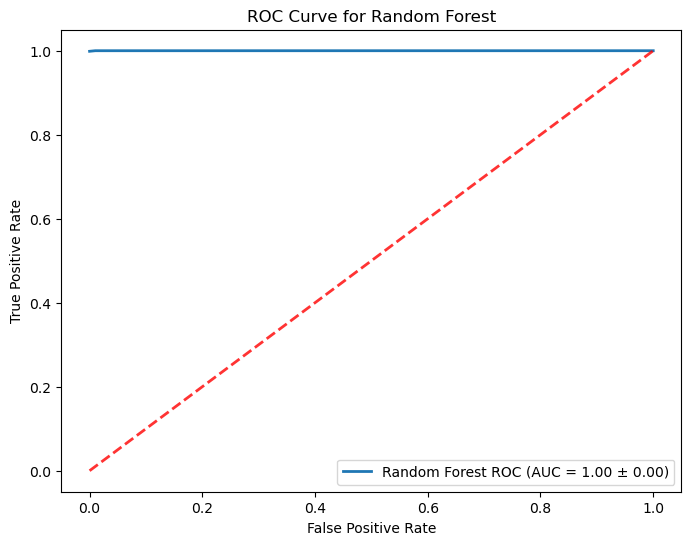

Metrics for Model Name:  Random Forest
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


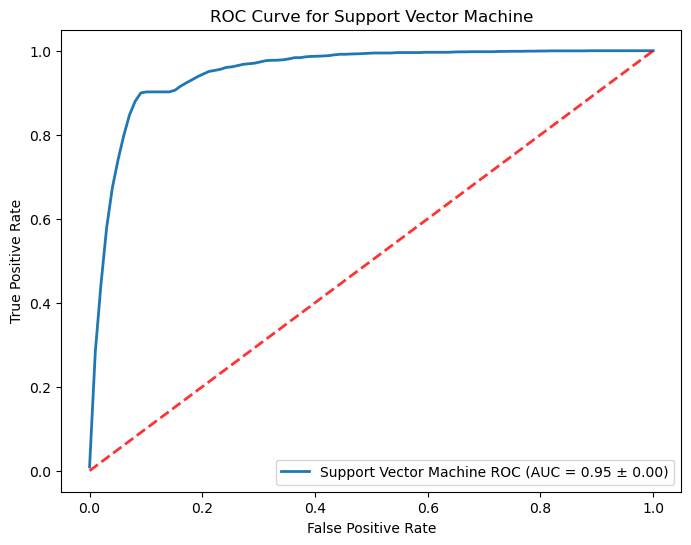

Metrics for Model Name:  Support Vector Machine
Accuracy: 0.91
Precision: 0.78
Recall: 0.27


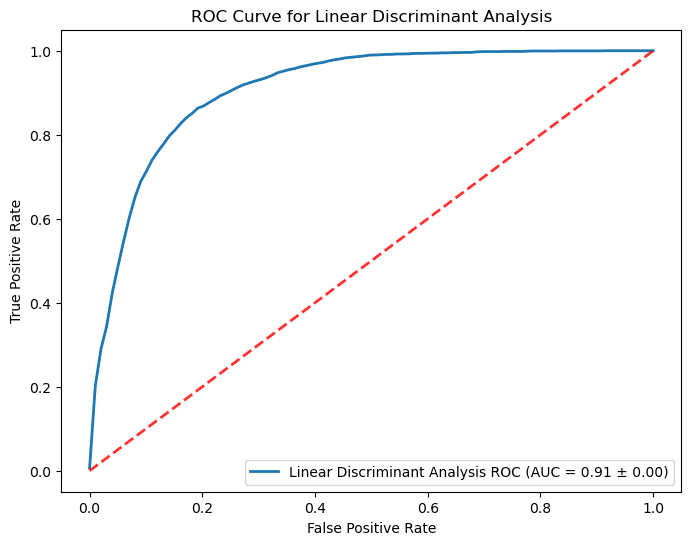

Metrics for Model Name:  Linear Discriminant Analysis
Accuracy: 0.90
Precision: 0.60
Recall: 0.34


In [77]:
for model, name, dense_transform in models:
    trained_pipeline = train_model(X_train, Y_train, model, dense_transform)
    metrics = evaluate_model(X_train, Y_train, trained_pipeline, name)

    print(f"Metrics for Model Name: ", name)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")